This notebook trains a neural network and then scores it on the test set. It then plots the weights, then optimises the inputs and plots them both as a heat map and a network. It then selects a reactant, transition state and product structure and see how they activate each neuron in the network. The activations are plotted as a bar plot to be compared to each other.

In [1]:
import joblib
import sys
sys.path.insert(0,'/Users/walfits/Repositories/Aglaia/')
import energies_NN as nn
import numpy as np
from sklearn import model_selection as modsel

In [2]:
# Loading the data
data = joblib.load("cc_kjmol_invdist.bz")
X = data["X"]
y = np.reshape(data["y"], (data["y"].shape[0],))

In [3]:
# Splitting the data
X_train, X_test, y_train, y_test = modsel.train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

(16558, 21)


In [4]:
# Training the model
estimator = nn.Energies_NN(max_iter=20000, learning_rate_init=0.05, hidden_layer_sizes=(3,), batch_size=1000, alpha= 0.001275, alpha_l1=0.0)

In [5]:
estimator.fit(X_train, y_train)

In [6]:
print("First layer weights:")
weights1 = estimator.all_weights[1][0]
print(estimator.all_weights[0][0])
print("First layer biases:")
print(estimator.all_biases[0])
print("Second layer weights:")
print(weights1)
print("Max and min value of second layer weights:")
print(weights1.max(), weights1.min())
print("Second layer bias:")
print(estimator.all_biases[1])

First layer weights:
[ -1.08276534  20.78652954 -11.17630291  10.46918201  44.11167908
  24.19782257 -13.99136925  -8.12734509 -12.36991692  -7.77869558
 -10.02829933 -20.1477623  -20.19987869   9.38602161 -17.78424072
 -15.72157574  12.27759743 -19.38509178  -1.39491022 -17.10600853
  17.11571312]
First layer biases:
[ -1.79139495   1.51732349 -55.57446671]
Second layer weights:
[-152.06089783 -136.84364319 -117.44504547]
Max and min value of second layer weights:
-117.445 -152.061
Second layer bias:
[ 133.2746582]


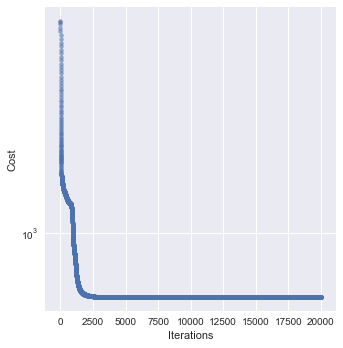

In [7]:
estimator.plot_cost()

In [8]:
estimator.scoreFull(X_test, y_test)

(0.90336363186861679,
 24.123524631631735,
 17.95754665181752,
 150.07661782176001,
 149.54311576212058)

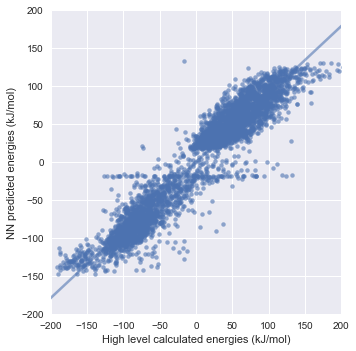

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
y_pred = estimator.predict(X_test)
df = pd.DataFrame()
df['High level calculated energies (kJ/mol)'] = y_test
df['NN predicted energies (kJ/mol)'] = y_pred
lm = sns.lmplot('High level calculated energies (kJ/mol)', 'NN predicted energies (kJ/mol)', data=df,
                scatter_kws={"s": 20, "alpha": 0.6}, line_kws={"alpha": 0.5})
lm.set(ylim=(-200,200), xlim=(-200,200))
plt.show()

In [10]:
np.random.seed(seed=1)
random_input = abs(np.random.rand(21))
print(random_input.shape)

(21,)


/Users/walfits/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


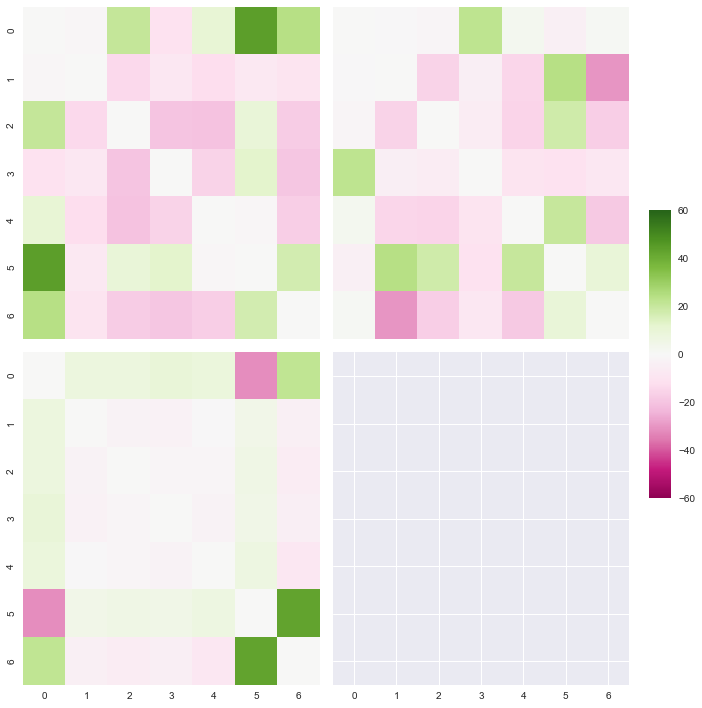

In [11]:
estimator.plotWeights(with_diag=False, show_fig=True)

The activations at the end of the optimisations are:
[array([[ 0.9989875]], dtype=float32), array([[ 0.99773395]], dtype=float32), array([[ 0.99366355]], dtype=float32)]


/Users/walfits/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


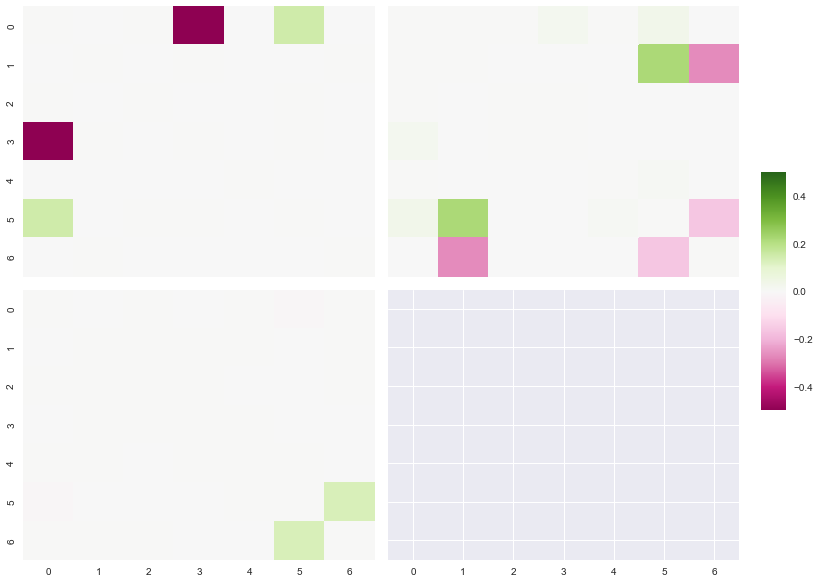

In [12]:
the_mean = np.mean(X_train, axis=0)
estimator.isVisReady = False
# alpha_l1 = [0.0001, 0.0000001, 0.001, 0.05, 0.005, 0.005, 0.1, 0.5, 0.05, 0.01, 0.0000001, 0.0000005, 0.0000001] 
# alpha_l1 = [1.0, 0.001, 0.0000001, 0.0000001, 0.01, 0.0000001, 1.0, 0.0000001, 0.0001, 0.005, 1.0, 0.0000001, 0.000001]
# alpha_l1 =  [0.05, 1.0, 0.005, 0.0000001, 1.0, 0.0000001, 1.0, 0.05, 0.0000001, 0.05, 0.0000001, 0.01, 0.0001]
alpha_l1 = [0.01, 0.01, 0.05]
## New reg L1
# alpha_l1 = [0.0005, 0.01, 0.01, 1.0, 1.0, 1.0, 1.0, 0.001, 0.01, 0.01, 1.0, 1.0, 1.0]

alpha_l2=0.0

if estimator.isVisReady == False:
    estimator.x_square_tot = estimator.optimise_input(random_input, alpha_l1, alpha_l2, the_mean, 6000, 0.0005, with_diag=False)

max_val = np.amax(estimator.x_square_tot)
min_val = np.amin(estimator.x_square_tot)

n = int(np.ceil(np.sqrt(estimator.hidden_layer_sizes[0])))
additional = n ** 2 - estimator.hidden_layer_sizes[0]

fig, axn = plt.subplots(n, n, sharex=True, sharey=True)
fig.set_size_inches(11.7, 8.27)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
counter = 0

for i, ax in enumerate(axn.flat):
    df = pd.DataFrame(estimator.x_square_tot[counter])
    ax.set(xticks=[], yticks=[])
    sns.heatmap(df, ax=ax, cbar=i == 0, cmap='PiYG',
                vmax=0.5, vmin=-0.5,
                cbar_ax=None if i else cbar_ax)
    counter = counter + 1
    if counter >= estimator.hidden_layer_sizes[0]:
        break

fig.tight_layout(rect=[0, 0, 0.9, 1])
# if write_plot==True:
#     fig.savefig("high_a1_input.png", transparent=False, dpi=600)
plt.show()

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

matrix = estimator.x_square_tot

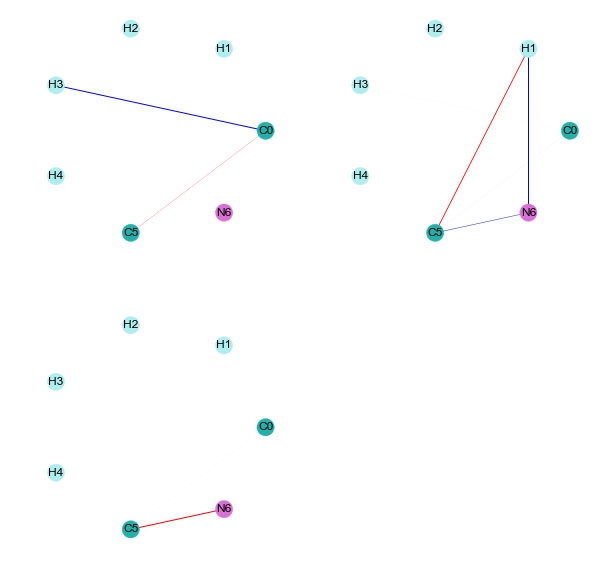

In [14]:
# for i in range(len(estimator.x_square_tot)):
#     matrix[i] = estimator.x_square_tot[i] * estimator.all_weights[1][0][i] * 0.001

# for i in range(len(estimator.x_square_tot)):
#     matrix[i] = matrix[i] * 0.1

# max_val = np.amax(matrix)
# min_val = np.amin(matrix)


n = int(np.ceil(np.sqrt(estimator.hidden_layer_sizes)))

fig = plt.figure(figsize=(10, 10))
for i in range(n**2):
    if i >= estimator.hidden_layer_sizes[0]:
        break
    fig.add_subplot(n,n,1+i)
    A = np.matrix(matrix[i])
    graph2 = nx.from_numpy_matrix(A, parallel_edges=False)
    

    labels = {}
    labels[0] = 'C0'
    labels[1] = 'H1'
    labels[2] = 'H2'
    labels[3] = 'H3'
    labels[4] = 'H4'
    labels[5] = 'C5'
    labels[6] = 'N6'

    colors = ["lightseagreen", "paleturquoise", "paleturquoise", "paleturquoise", "paleturquoise", "lightseagreen", "orchid"]

    # edges widths
    edgewidth = [abs(d['weight']) for (u, v, d) in graph2.edges(data=True)]
    if len(edgewidth) > 0:
        if len(edgewidth)==1:
            norm_fact = edgewidth[0]
        else:
            norm_fact = max(edgewidth)
        edge_std_list = np.ones(len(edgewidth)) * norm_fact
        edgewidth = edgewidth/edge_std_list
        
    # Added so that the negative and positive features have different colours     
    edgecolours = [d['weight'] for (u, v, d) in graph2.edges(data=True)]
    if len(edgecolours) > 0:
        if len(edgecolours)==1:
            norm_fact = abs(edgecolours[0])
        else:
            norm_fact = abs(max(edgecolours))
        edge_std_list = np.ones(len(edgecolours)) * norm_fact
        edgecolours = edgecolours/edge_std_list
    

    plt.axis('off')
    nx.draw_circular(graph2,
                     width=edgewidth,
                     with_labels=True, 
                     labels=labels, 
                     node_color=colors,
                     edge_color=edgecolours, 
                     edge_cmap=plt.cm.bwr,
                     edge_vmin=-1,
                     edge_vmax=1
                     )

# plt.savefig("mod1tot_noweight.png", dpi=200)  # save as png

plt.show()  # display

In [15]:
# plt.savefig("mod1tot_noweight.png", dpi=200)  # save as png

In [16]:
# Loading the 3 structure data
data = joblib.load("three_struct.bz")
X_three = data["X_id"]
print(X_three)

[[ 0.87510607  1.0068308   0.94992392  0.91841698  0.18035015  0.15578483
   0.60307448  0.54848708  0.55906988  0.22085972  0.18455364  0.59249589
   0.52462901  0.17299739  0.14782007  0.64591918  0.17634902  0.15513135
   0.16155382  0.1435838   0.83910112]
 [ 0.88200481  0.81674433  0.93614248  0.92559422  0.42269957  0.32117401
   0.51894718  0.51861109  0.51027058  0.32797343  0.28770604  0.62809019
   0.54308518  0.79055202  0.50631531  0.60669835  0.44902345  0.31750656
   0.34207254  0.26277005  0.87452648]
 [ 0.87448072  0.33432221  0.92767791  0.89592108  0.2539097   0.20026331
   0.37577343  0.50562463  0.47974899  0.26940556  0.20691386  0.30306459
   0.27589215  0.93801918  0.45616395  0.59650025  0.24080925  0.19489901
   0.22536769  0.1850881   0.88726619]]


In [17]:
activations = estimator.max_act(X_three)
print(activations)

[[  2.99592067e-08   3.42564344e-05   9.05702531e-01]
 [  1.59823205e-04   8.81043903e-04   6.74553156e-01]
 [  6.22591906e-05   9.99948382e-01   8.73674452e-01]]


In [18]:
dfc = pd.DataFrame()

dfc["node0"]=activations[0,:]
dfc["node1"]=activations[1,:]
dfc["node2"]=activations[2,:]
dfc["node_list"] = range(12)

ValueError: Length of values does not match length of index

In [ ]:
fig, ax = plt.subplots()
sns.barplot( x=dfc["node_list"], y=dfc["node0"] , color="skyblue", label="CH4_CN")
ax.set(xlabel='Node', ylabel='Activation')
ax.set(ylim=(0,1.01))
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.barplot( x=dfc["node_list"], y=dfc["node1"] , color="skyblue", label="CH3-H-CN")
ax.set(xlabel='Node', ylabel='Activation')
ax.set(ylim=(0,1.01))
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.barplot( x=dfc["node_list"], y=dfc["node2"] , color="skyblue", label="CH3_HCN")
ax.set(xlabel='Node', ylabel='Activation')
ax.set(ylim=(0,1.01))
plt.show()

In [ ]:
activations_all = estimator.max_act(X)

In [ ]:
print("The max and min activations for neuron 0 are:")
print(max(activations_all[:,0]), min(activations_all[:,0]))

print("The max and min activations for neuron 1 are:")
print(max(activations_all[:,1]), min(activations_all[:,1]))

print("The max and min activations for neuron 2 are:")
print(max(activations_all[:,2]), min(activations_all[:,2]))